In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import oskar
# scripts = oskar.Scripts()
import numpy as np
from tqdm import tqdm
import numpy
import matplotlib.pyplot as plot
import sys
import pickle as pkl
# import pyvisa as visa
import pyvisa as visa
import datetime
from scipy.optimize import curve_fit

from collections import defaultdict
from scipy.stats import kurtosis, skew
import pandas as pd
# import xarray as xr
from collections import OrderedDict
from pathlib import Path
import fnmatch
import time
rm = visa.ResourceManager()
instruments = rm.list_resources()
# instruments
# usb = list(filter(lambda x: 'USB' in x, instruments))
# if len(usb) != 1:
#     print('Bad instrument list', instruments)
#     sys.exit(-1)
# keithley = rm.open_resource(usb[0])
instruments

('ASRL/dev/ttyS4::INSTR',
 'ASRL/dev/ttyS31::INSTR',
 'ASRL/dev/ttyS30::INSTR',
 'ASRL/dev/ttyS29::INSTR',
 'ASRL/dev/ttyS28::INSTR',
 'ASRL/dev/ttyS27::INSTR',
 'ASRL/dev/ttyS26::INSTR',
 'ASRL/dev/ttyS25::INSTR',
 'ASRL/dev/ttyS24::INSTR',
 'ASRL/dev/ttyS23::INSTR',
 'ASRL/dev/ttyS22::INSTR',
 'ASRL/dev/ttyS21::INSTR',
 'ASRL/dev/ttyS20::INSTR',
 'ASRL/dev/ttyS19::INSTR',
 'ASRL/dev/ttyS18::INSTR',
 'ASRL/dev/ttyS17::INSTR',
 'ASRL/dev/ttyS16::INSTR',
 'ASRL/dev/ttyS15::INSTR',
 'ASRL/dev/ttyS14::INSTR',
 'ASRL/dev/ttyS13::INSTR',
 'ASRL/dev/ttyS12::INSTR',
 'ASRL/dev/ttyS11::INSTR',
 'ASRL/dev/ttyS10::INSTR',
 'ASRL/dev/ttyS9::INSTR',
 'ASRL/dev/ttyS8::INSTR',
 'ASRL/dev/ttyS7::INSTR',
 'ASRL/dev/ttyS6::INSTR',
 'ASRL/dev/ttyS5::INSTR',
 'ASRL/dev/ttyS3::INSTR',
 'ASRL/dev/ttyS2::INSTR',
 'ASRL/dev/ttyS1::INSTR',
 'ASRL/dev/ttyS0::INSTR',
 'ASRL/dev/ttyUSB0::INSTR',
 'USB0::62700::4870::SSA5PA1Q800415::0::INSTR',
 'USB0::6833::3601::DP8B260200018::0::INSTR',
 'TCPIP::192.168.1.101::

In [12]:
class SSA3032X_R: 
    def __init__(self, ip='TCPIP::192.168.169.104::INSTR', N_AVG=100, data_trace=3):
        rm = visa.ResourceManager()
        self.SSA = rm.open_resource(ip)
        self.N_AVG = N_AVG
        self.SSA.write(f":AVERage:TRACe{data_trace}:COUNt {N_AVG}")
        self.data_trace = data_trace
        # print('>>> Initialized', self.SSA.query("*IDN?"))
    
    def set_N_AVG(self, N):
        self.N_AVG = N 
        self.SSA.write(f":AVERage:TRACe{self.data_trace}:COUNt {N}")
        print(f'>>> Set N_AVG to {N}')

    def get_data(self, trace=None):
        trace = self.data_trace if trace is None else trace
        self.SSA.write(f":AVERage:TRAC{trace}:CLEar")
        # while int(self.SSA.query(f":AVERage:TRACe{trace}?")) < self.N_AVG: 
        #     continue
        data_str_C = self.SSA.query(f":TRACe{trace}:DATA?")
        return np.array([float(val) for val in data_str_C.split(',')])
    
    def get_tot_power_nW(self, trace=None): 
        data_dBm = self.get_data(trace) 
        data_mW = sum(10**(data_dBm/10))
        return data_mW*1e6  #FIXME

In [17]:
SSA = SSA3032X_R(ip='TCPIP::192.168.169.102::INSTR' )

In [23]:
data_C = SSA.SSA.query("TRAC3:DATA?")
data_arr_C = np.array([float(val) for val in data_C.split(',')])
data_B = SSA.SSA.query("TRAC2:DATA?")
data_arr_B = np.array([float(val) for val in data_B.split(',')])

In [29]:
laser_off = SSA.SSA.query("TRAC3:DATA?")
laser_off_arr = np.array([float(val) for val in laser_off.split(',')])

In [32]:
RF_off = SSA.SSA.query("TRAC3:DATA?")
RF_off_arr = np.array([float(val) for val in laser_off.split(',')])

In [34]:
RF_off_arr = np.array([float(val) for val in RF_off.split(',')])

In [38]:
iP_MCP_off = SSA.SSA.query("TRAC3:DATA?")
iP_MCP_off_arr = np.array([float(val) for val in iP_MCP_off.split(',')])

In [42]:
all_off = SSA.SSA.query("TRAC3:DATA?")
all_off_arr = np.array([float(val) for val in all_off.split(',')])

In [45]:
amp_off = SSA.SSA.query("TRAC3:DATA?")
amp_off_arr = np.array([float(val) for val in amp_off.split(',')])

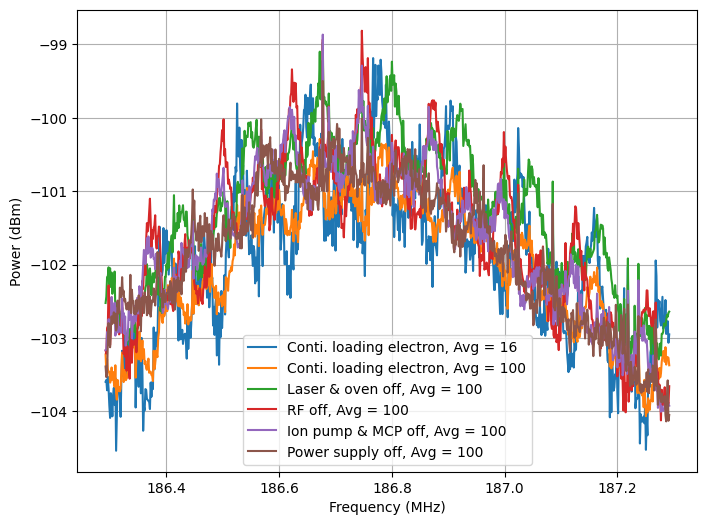

In [43]:
# Number of points in the trace
num_points = len(data_arr)
freq_center = 186.792
freq_span = 1
# Generate frequency axis in MHz
freq_start = freq_center - freq_span / 2
freq_stop  = freq_center + freq_span / 2
freq_axis = np.linspace(freq_start, freq_stop, num_points)

# --- Plot ---
plt.figure(figsize=(8,6))
# plot(freq_axis, data_arr, label="Avg = 1")
plt.plot(freq_axis, data_arr_B, label="Conti. loading electron, Avg = 16")
plt.plot(freq_axis, data_arr_C, label="Conti. loading electron, Avg = 100")
plt.plot(freq_axis, laser_off_arr, label="Laser & oven off, Avg = 100")
plt.plot(freq_axis, RF_off_arr, label="RF off, Avg = 100")
plt.plot(freq_axis, iP_MCP_off_arr, label="Ion pump & MCP off, Avg = 100")
plt.plot(freq_axis, all_off_arr, label="Power supply off, Avg = 100")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBm)")
plt.grid(True)
plt.legend()
plt.show()

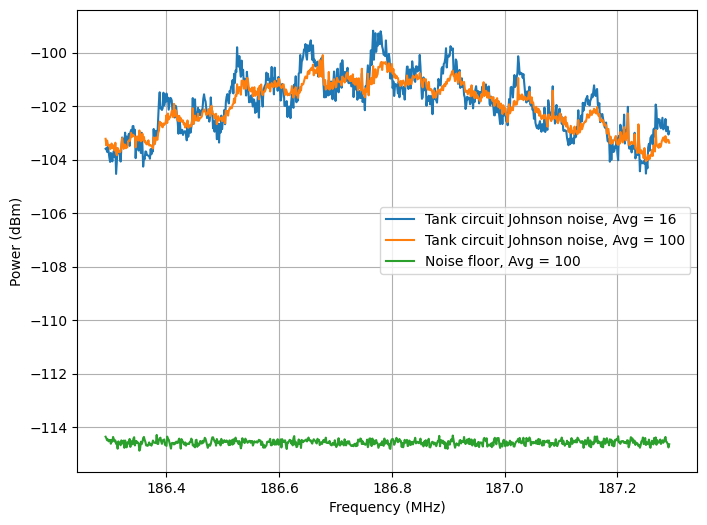

In [48]:
# Number of points in the trace
num_points = len(data_arr)
freq_center = 186.792
freq_span = 1
# Generate frequency axis in MHz
freq_start = freq_center - freq_span / 2
freq_stop  = freq_center + freq_span / 2
freq_axis = np.linspace(freq_start, freq_stop, num_points)

# --- Plot ---
plt.figure(figsize=(8,6))
# plot(freq_axis, data_arr, label="Avg = 1")
plt.plot(freq_axis, data_arr_B, label="Tank circuit Johnson noise, Avg = 16")
plt.plot(freq_axis, data_arr_C, label="Tank circuit Johnson noise, Avg = 100")
# plt.plot(freq_axis, laser_off_arr, label="Laser & oven off, Avg = 100")
plt.plot(freq_axis, amp_off_arr, label="Noise floor, Avg = 100")

plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBm)")
plt.grid(True)
plt.legend()
plt.show()